The contents of this course including lectures, labs, homework assignments, and exams have all been adapted from the [Data 8 course at University California Berkley](https://data.berkeley.edu/education/courses/data-8). Through their generosity and passion for undergraduate education, the Data 8 community at Berkley has opened their content and expertise for other universities to adapt in the name of undergraduate education.

In [2]:
#!pip install datascience
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Chapter 12 Comparing Two Samples

In this chapter, we develop a way of using Python to compare two random samples and answer questions about the similarities and differences between them. You will see that the methods we develop have diverse applications. Our examples are from medicine and public health.

* In modern data analytics, deciding whether two numerical samples come from the same underlying distribution is called A/B testing.

We will develop the method in the context of an example. The data come from a sample of newborns in a large hospital system. We will treat it as if it were a simple random sample though the sampling was done in multiple stages. [Stat Labs](https://www.stat.berkeley.edu/~statlabs/) by Deborah Nolan and Terry Speed has details about a larger dataset from which this set is drawn.

* The table births contains the following variables for 1,174 mother-baby pairs
    * The baby’s birth weight in ounces
    * The number of gestational days
    * The mother’s age in completed years
    * The mother’s height in inches
    * Pregnancy weight in pounds
    * Whether or not the mother smoked during pregnancy.

In [3]:
births = Table.read_table('baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


Lets do some EDA (Exploratory Data Analysis) on this data set. Are there any associations that jump out?

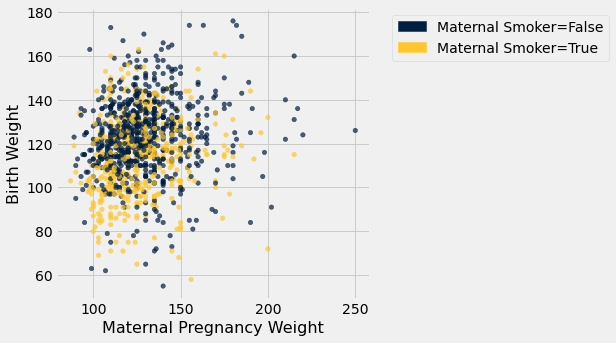

In [4]:
births.scatter('Maternal Pregnancy Weight', 'Birth Weight', group = 'Maternal Smoker')

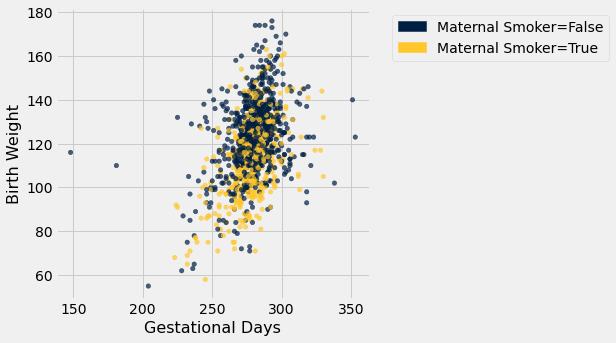

In [5]:
births.scatter('Gestational Days', 'Birth Weight', group = 'Maternal Smoker')

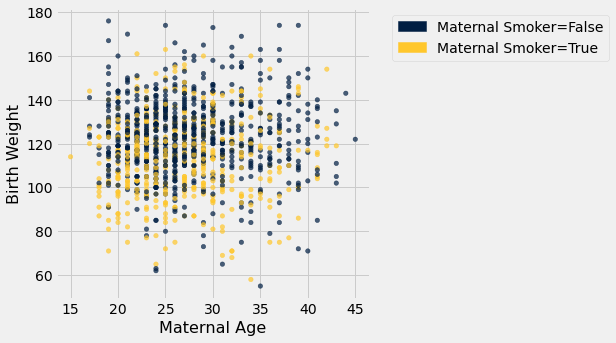

In [6]:
births.scatter('Maternal Age', 'Birth Weight', group = 'Maternal Smoker')

We’ll start by selecting just Birth Weight and Maternal Smoker. There are 715 non-smokers among the women in the sample, and 459 smokers.

In [7]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [8]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


Let’s look at the distribution of the birth weights of the babies of the non-smoking mothers compared to those of the smoking mothers.

C:\Users\ksorauf\AppData\Local\Continuum\anaconda3\lib\site-packages\datascience\tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(tuple(values))


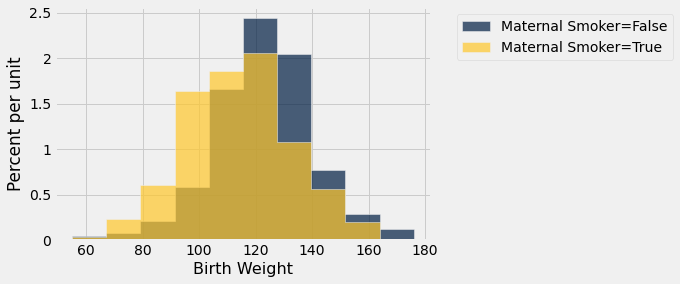

In [10]:
smoking_and_birthweight.hist('Birth Weight', group = 'Maternal Smoker')

* The distribution of smokers appears to be based slightly to the left of the distribution corresponding to non-smoking mothers. 
* This raises the question of whether the difference reflects just chance variation or a difference in the distributions in the larger population. 
* We can try to answer this question by a test of hypotheses. 
* The **null hypthosis** says that there is no underlying difference in the populations; the distributions in the samples are different just due to chance.

**Null hypothesis:** In the population, the distribution of birth weights of babies is the same for mothers who don’t smoke as for mothers who do. The difference in the sample is due to chance.

**Alternative hypothesis:** In the population, the babies of the mothers who smoke have a lower birth weight, on average, than the babies of the non-smokers.

In [11]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [12]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

Let's wrap it into a function so we can simulate the difference repeatedely.  

In [13]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean birth weights of the two groups"""
    reduced = table.select('Birth Weight', group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

In [14]:
difference_of_means(births, 'Maternal Smoker')

-9.266142572024918

* To see how the statistic should vary under the null hypothesis, we have to figure out how to simulate the statistic under that hypothesis.
* If there were no difference between the two distributions in the underlying population, then whether a birth weight has the label True or False with respect to maternal smoking should make no difference to the average. 
* The idea, then, is to shuffle all the labels randomly among the mothers. 
    * This is called random permutation.

* Shuffling ensures that the count of True and False labels does not change.
* We will reduced the table to have just the columns that we need.

In [15]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


* To shuffle all the labels, we will draw a random sample of 1,174 rows without replacement. T
* The sample will include all the rows of the table, in random order.
* We can use the Table method *sample* with the optional *with_replacement=False* argument. We don’t have to specify a sample size, because by default, sample draws as many times as there are rows in the table.

In [17]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement = False).column(0)
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Label', shuffled_labels)
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,True
False,113,True
True,128,False
True,108,False
False,136,True
False,138,False
False,132,False
False,120,True
True,143,False
False,140,True


Let’s see how different the average weights are in the two randomly labeled groups.

In [18]:
shuffled_only = original_and_shuffled.select('Birth Weight','Shuffled Label')
shuffled_group_means = shuffled_only.group('Shuffled Label', np.average)
shuffled_group_means

Shuffled Label,Birth Weight average
False,119.432
True,119.51


In [19]:
difference_of_means(original_and_shuffled, 'Shuffled Label')

0.07763608940079791

In [20]:
difference_of_means(original_and_shuffled, 'Maternal Smoker')

-9.266142572024918

* Could a different shuffle have resulted in a larger difference between the group averages? 
* To get a sense of the variability, we must simulate the difference many times.
* As always, we will start by defining a function that simulates one value of the test statistic under the null hypothesis. 

In [23]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean birthweights
    of babies of smokers and non-smokers after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
    
    # table of birth weights and shuffled labels
    shuffled_table = births.select('Birth Weight').with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Label')   

In [33]:
one_simulated_difference_of_means()

0.13844935021406002

Tests based on random permutations of the data are called permutation tests. We are performing one in this example. In the cell below, we will simulate our test statistic – the difference between the average birth weight of the two randomly formed groups – many times and collect the differences in an array.

In [34]:
differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    differences = np.append(differences, new_difference)                               

In [35]:
differences

array([ 1.01129851, -0.21212121,  2.19536847, ..., -0.21927571,
       -0.93472584,  1.19016104])

Observed Difference: -9.266142572024918


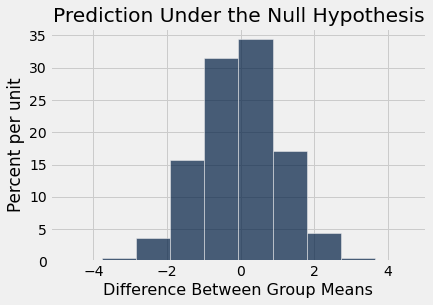

In [36]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');

In [37]:
Table().with_column('Difference Between Group Means', differences)

Difference Between Group Means
1.0113
-0.212121
2.19537
0.113409
-0.319439
-0.119113
-0.197812
-0.548383
1.00772
-0.151308


* The distribution is centered roughly around 0.
* The difference between the group averages should be around 0.
* The observed difference in the original sample doesn’t even appear on the horizontal scale of the histogram. 
* The observed value of the statistic and the predicted behavior of the statistic under the null hypothesis are inconsistent.

The conclusion of the test is that the data favor the alternative over the null. It supports the hypothesis that the average birth weight of babies born to mothers who smoke is less than the average birth weight of babies born to non-smokers.

* Compute an empirical p-value
    * Remember that low values of the statistic favor the alternative hypothesis.

In [38]:
empirical_p = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_p

0.0

In [39]:
np.count_nonzero(differences <= observed_difference)

0

* We can use the same method to compare other attributes of the smokers and the non-smokers, such as their ages. 
* Histograms of the ages of the two groups show that in the sample, the mothers who smoked tended to be younger.

C:\Users\ksorauf\AppData\Local\Continuum\anaconda3\lib\site-packages\datascience\tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(tuple(values))


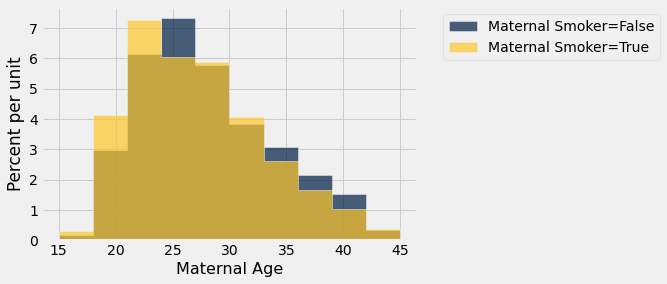

In [40]:
smoking_and_age = births.select('Maternal Smoker', 'Maternal Age')
smoking_and_age.hist('Maternal Age', group = 'Maternal Smoker')

In [41]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean ages of the two groups"""
    reduced = table.select('Maternal Age', group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

In [42]:
observed_age_difference = difference_of_means(births, 'Maternal Smoker')
observed_age_difference

-0.8076725017901509

In [45]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean ages
    of smokers and non-smokers after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
    
    # table of ages and shuffled labels
    shuffled_table = births.select('Maternal Age').with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Label')   

In [46]:
shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
shuffled_table = births.select('Maternal Age').with_column(
        'Shuffled Label', shuffled_labels)
births

Maternal Age,Shuffled Label
27,True
33,False
28,False
23,True
25,False
33,False
23,False
25,False
30,True
27,True


In [48]:
age_differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    age_differences = np.append(age_differences, new_difference)

Observed Difference: -0.8076725017901509


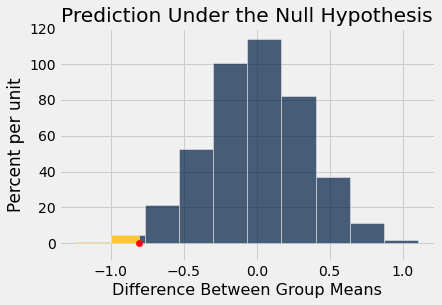

In [49]:
Table().with_column(
    'Difference Between Group Means', age_differences).hist(
    right_end = observed_age_difference)
# Plotting parameters; you can ignore the code below
plots.ylim(-0.1, 1.2)
plots.scatter(observed_age_difference, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_age_difference)

In [50]:
empirical_p = np.count_nonzero(age_differences <= observed_age_difference) / 5000
empirical_p

0.0094

The empirical p-value is around 1% and therefore the result is statistically significant. The test supports the hypothesis that the smokers were younger on average.

## Another example: Treating Chronic Back Pain: A Randomized Controlled Trial

* A randomized controlled trial (RCT) examined the effect of using Botulinum Toxin A (BTA) as a treatment for lower back pain. 
* Thirty one patients with low-back pain were randomized into treatment and control groups
* 15 in the treatment group
* 16 in control were given saline solution 
* Trials were run double-blind so that neither doctors nor patients knew which group they were in

* 9 of the 15 in the treatment group and 2 of the 16 in the control group had pain relief 
* These data are in the table bta and appear to show that the treatment has a clear benefit.

In [51]:
bta = Table.read_table('bta.csv')
bta.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


In [52]:
bta.group('Group', sum)

Group,Result sum
Control,2
Treatment,9


In [53]:
bta.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


* The indications are that botulinum toxin A did better than the saline
* But the conclusion isn’t yet a slam-dunk
* Patients were assigned at random into the two groups, so perhaps the difference could just be due to chance?

* There are 31 potential treatment outcomes 
* And 31 potential control outcomes
* Are these two groups the same, or are they different?

The table *observed_outcomes* collects the information about every patient’s potential outcomes, leaving the unobserved half of each “ticket” blank. (It’s just another way of thinking about the bta table, carrying the same information.)

In [54]:
observed_outcomes = Table.read_table("observed_outcomes.csv")
observed_outcomes.show()

Group,Outcome if assigned treatment,Outcome if assigned control
Control,Unknown,1
Control,Unknown,1
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0


The question is whether the treatment does anything. In terms of the table observed_outcomes, the question is whether the distribution of the 31 “treatment” values in Column 2 (including the unknown ones) is different from the distribution of the 31 “control” values in Column 3 (again including the unknown ones).

**Null Hypothesis**: The distribution of all 31 potential “treatment” outcomes is the same as that of all 31 potential “control” outcomes. Botulinum toxin A does nothing different from saline; the difference in the two samples is just due to chance.

**Alternative Hypothesis**: The distribution of 31 potential “treatment” outcomes is different from that of the 31 control outcomes. The treatment does something different from the control.

There are 31 observed outcomes jointly in the two groups. If the null hypothesis were true, it wouldn’t matter which of those 31 outcomes were labeled “treatment” and which “control.” Any random subset of 16 out of the 31 values could be called “control” and the remaining 15 “treatment”.

We can simulate this. We can randomly permute the 31 values, split them into two groups of 16 and 15, and see how different the distributions in the two groups are. Since the data are zeros and ones, we can just see how different the two proportions are.

That’s exactly what we did for A/B testing in the previous section. Sample A is now the control group and Sample B the treatment group. We will carry out the test below showing the details of all the steps. You should confirm that they are the same as the steps carried out for A/B testing.

In [55]:
bta.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


In [56]:
observed_proportions = bta.group('Group', np.average).column(1)
observed_distance = abs(observed_proportions.item(0) - observed_proportions.item(1))
observed_distance

0.475

In [61]:
def distance(table, group_label):
    reduced = table.select('Result', group_label)
    proportions = reduced.group(group_label, np.average).column(1)
    return abs(proportions.item(1) - proportions.item(0))

In [96]:
from scipy import stats

In [105]:
stats.ttest_ind(bta.where('Group', 'Treatment').column('Result'), bta.where('Group', 'Control').column('Result'))

Ttest_indResult(statistic=3.077092073464823, pvalue=0.0045326763187706915)

C:\Users\ksorauf\AppData\Local\Continuum\anaconda3\lib\site-packages\datascience\tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(tuple(values))


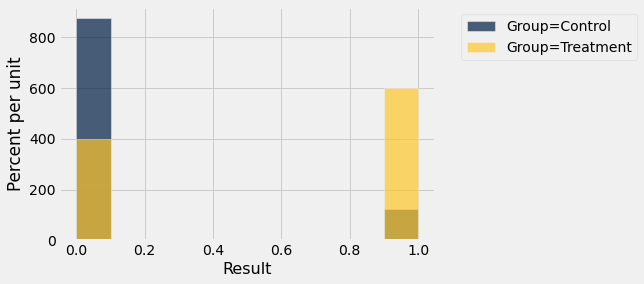

In [116]:
bta.select('Group', 'Result').hist(group = 'Group')

In [ ]:
np.count_nonzero(distances >= observed_distance) / repetitions

In [99]:
distance(bta, 'Group')

0.475

In [75]:
shuffled_labels = bta.sample(with_replacement=False).column(0)

In [124]:
stats.ttest_ind(bta_with_shuffled_labels.where('Shuffled Label', 'Treatment').column('Result'), bta_with_shuffled_labels.where('Shuffled Label', 'Control').column('Result'))

Ttest_indResult(statistic=2.0860211872649526, pvalue=0.04588230430891461)

In [76]:
bta_with_shuffled_labels = bta.with_column('Shuffled Label', shuffled_labels)
bta_with_shuffled_labels.show()

Group,Result,Shuffled Label
Control,1,Treatment
Control,1,Treatment
Control,0,Treatment
Control,0,Control
Control,0,Treatment
Control,0,Treatment
Control,0,Control
Control,0,Control
Control,0,Control
Control,0,Treatment


In [77]:
distance(bta_with_shuffled_labels, 'Shuffled Label')

0.3458333333333333

In [125]:
def one_simulated_distance():
    shuffled_labels = bta.sample(with_replacement = False).column('Group')
    shuffled_table = bta.select('Result').with_column(
        'Shuffled Label', shuffled_labels)
    return distance(shuffled_table, 'Shuffled Label'), stats.ttest_ind(shuffled_table.where('Shuffled Label', 'Treatment').column('Result'), shuffled_table.where('Shuffled Label', 'Control').column('Result'))[1]


In [126]:
one_simulated_distance()

(0.17083333333333334, 0.3368714593507567)

In [145]:
distances = make_array()
p_vals = make_array()
repetitions = 20
for i in np.arange(repetitions):
    new_distance = one_simulated_distance()
    distances = np.append(distances, new_distance[0])
    p_vals = np.append(p_vals, new_distance[1])

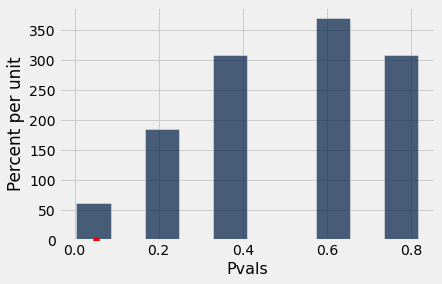

In [146]:
Table().with_column('Pvals', p_vals).hist()
plots.scatter(0.05, 0, color='red', s=40, zorder=3)

In [147]:
np.count_nonzero(p_vals <= 0.05) / repetitions

0.05

Observed Distance 0.475


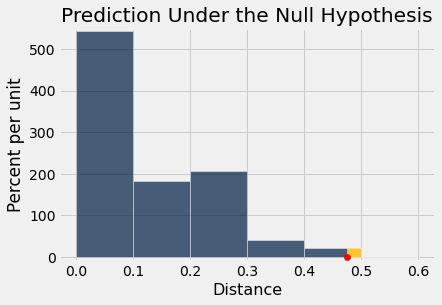

In [107]:
Table().with_column('Distance', distances).hist(
    bins = np.arange(0, 0.7, 0.1), left_end = observed_distance)
# Plotting parameters; you can ignore the code below
plots.ylim(-0.1, 5.5)
plots.scatter(observed_distance, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Distance', observed_distance)

In [89]:
empirical_p = np.count_nonzero(distances >= observed_distance) / repetitions
empirical_p

0.0

This is a small p-value. The observed statistic is in the tail of the empirical histogram of the test statistic generated under the null hypothesis.

The result is statistically significant. The test favors the alternative hypothesis over the null. The evidence supports the hypothesis that the treatment is doing something.

The study reports a P-value of 0.009, or 0.9%, which is not far from our empirical value.

Because the trials were randomized, the test is evidence that the treatment causes the difference. The random assignment of patients to the two groups ensures that there is no confounding variable that could affect the conclusion of causality.

If the treatment had not been randomly assigned, our test would still point toward an association between the treatment and back pain outcomes among our 31 patients. **But beware**: without randomization, this association would not imply that the treatment caused a change in back pain outcomes. For example, if the patients themselves had chosen whether to administer the treatment, perhaps the patients experiencing more pain would be more likely to choose the treatment and more likely to experience some reduction in pain even without medication. Pre-existing pain would then be a confounding factor in the analysis.